In [35]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [36]:
train_filename = "./train.csv"
test_filename = "./test.csv"

<h3 style="text-align: center;"><b>Computer Vision BaseLine</b></h3>

This BaseLine contains simple CV methods which allow to solve simple tasks







In [37]:

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# MNIST Dataset


`train.csv` - file with training data

`test.csv` - file with test data (no target here)

In [38]:
dataset = pd.read_csv(train_filename, low_memory=False)
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


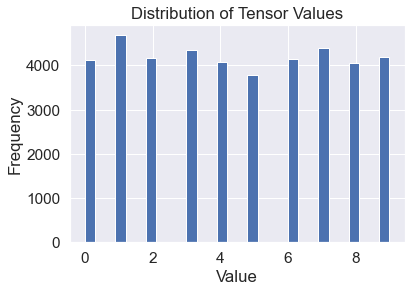

In [39]:
numpy_array = dataset['label'].values

plt.hist(numpy_array, bins=30)
plt.title("Distribution of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [40]:
test_size = 0.2
train_data, test_data = train_test_split(dataset, test_size=test_size, random_state=42)

# lets split train dataset on temp_train and test_train
# temp_train will contain training data to train our model
# and temp_test will contain test data with targets to estimate our score
train_data.to_csv("./temp_train.csv", index=False)
test_data.to_csv("./temp_test.csv", index=False)

In [41]:
to_watch_on = pd.read_csv("./temp_train.csv", low_memory=False)
to_watch_on

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33596,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33597,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33598,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# TARGET should be the first column

picture_height = 28
picture_width = 28

device = "cuda" if torch.cuda.is_available() else "cpu"

class CustomDataset(Dataset):
    def __init__(self, csv_file, is_train: bool, transform=None):
        self.is_train = is_train
        self.data = pd.read_csv(csv_file, low_memory=False)
        self.transform = transform
        print("Downloaded dataset with size: ", self.data.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.is_train):
          features = self.data.iloc[idx, 1:].values.reshape(picture_height, picture_width).astype(np.float32)
          target = torch.tensor(self.data.iloc[idx, 0], dtype=torch.int64)
          target = target.to(device)
        else:
          features = self.data.iloc[idx, 0:].values.reshape(picture_height, picture_width).astype(np.float32)
          target = torch.tensor(-1, dtype=torch.int32)

        if self.transform:
            features = self.transform(features)

        features = features.to(dtype=torch.float32)
        features = features.to(device)

        return features, target


train_dataset = CustomDataset("./temp_train.csv", True, transform=data_tfs)
test_dataset = CustomDataset("./temp_test.csv", True, transform=data_tfs)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

Downloaded dataset with size:  (33600, 785)
Downloaded dataset with size:  (8400, 785)


In [43]:
device

'cpu'

In [44]:
print("------train-----")
for x, y in train_dataloader:
  print(x.shape)
  print(x.dtype)
  print(y.dtype)
  print(y)
  break
print("------test-----")
for x, y in test_dataloader:
  print(x.shape)
  print(x.dtype)
  print(y)
  break

------train-----
torch.Size([128, 1, 28, 28])
torch.float32
torch.int64
tensor([0, 4, 1, 7, 0, 5, 6, 7, 3, 5, 2, 9, 6, 5, 2, 8, 0, 7, 1, 3, 0, 3, 6, 5,
        3, 4, 5, 9, 0, 4, 2, 6, 6, 2, 4, 8, 0, 4, 9, 8, 2, 4, 2, 3, 0, 7, 6, 0,
        5, 3, 3, 2, 1, 6, 9, 9, 1, 0, 9, 1, 3, 6, 3, 7, 9, 7, 7, 7, 8, 6, 6, 7,
        4, 4, 4, 1, 0, 3, 4, 2, 0, 1, 6, 7, 5, 7, 6, 3, 3, 0, 2, 6, 3, 8, 1, 2,
        1, 4, 2, 2, 3, 4, 1, 2, 3, 1, 3, 7, 2, 8, 0, 2, 3, 4, 9, 2, 6, 3, 3, 3,
        5, 9, 9, 3, 9, 8, 0, 5])
------test-----
torch.Size([128, 1, 28, 28])
torch.float32
tensor([4, 8, 0, 6, 2, 9, 5, 2, 7, 5, 4, 7, 3, 2, 5, 1, 4, 4, 0, 6, 3, 5, 4, 9,
        6, 2, 0, 7, 4, 5, 5, 1, 0, 4, 2, 6, 3, 1, 8, 2, 7, 7, 1, 1, 9, 8, 2, 7,
        3, 0, 5, 7, 8, 3, 6, 5, 1, 5, 4, 9, 2, 4, 0, 7, 6, 3, 9, 6, 4, 1, 7, 7,
        8, 6, 9, 5, 6, 5, 5, 9, 2, 0, 2, 0, 7, 2, 1, 3, 1, 6, 1, 9, 8, 6, 5, 5,
        3, 9, 1, 1, 5, 6, 3, 2, 5, 5, 1, 0, 1, 2, 7, 9, 7, 5, 2, 9, 5, 3, 7, 4,
        2, 2, 7, 2, 0, 9, 2, 2])


## Part 1 - fully-connected neural networks
Lets solve MNIST with FC NN.

### Here is a simple neural network

Lets build simple network with Sequential class. The network itself contains:
* (nn.Flatten);
* Two hidden layers 128 neurons each with nn.ELU activation
* Output layer with 10 neurons

We will use cross-entropy loss function


In [49]:
activation = nn.ELU
features = picture_height * picture_width   # number of flattened array
classes = 10                                # number of classes

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
    # don't need softmax here!
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [50]:
summary(model, (features,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

### Train loop


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Training process

In [52]:
max_epochs = 10
accuracy = {"train": [], "test": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            epoch_correct += (preds == y_batch).sum().item()
            epoch_all += batch_size
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8761032919847328
Loader: test. Accuracy: 0.928125
Epoch: 2
Loader: train. Accuracy: 0.9420920801526718
Loader: test. Accuracy: 0.9390625
Epoch: 3
Loader: train. Accuracy: 0.9595956583969466
Loader: test. Accuracy: 0.9490384615384615
Epoch: 4
Loader: train. Accuracy: 0.9656786736641222
Loader: test. Accuracy: 0.9493990384615385
Epoch: 5
Loader: train. Accuracy: 0.9696147423664122
Loader: test. Accuracy: 0.9493990384615385
Epoch: 6
Loader: train. Accuracy: 0.9708373091603053
Loader: test. Accuracy: 0.9599759615384615
Epoch: 7
Loader: train. Accuracy: 0.9751908396946565
Loader: test. Accuracy: 0.9552884615384616
Epoch: 8
Loader: train. Accuracy: 0.9798425572519084
Loader: test. Accuracy: 0.9585336538461539
Epoch: 9
Loader: train. Accuracy: 0.9784112595419847
Loader: test. Accuracy: 0.9557692307692308
Epoch: 10
Loader: train. Accuracy: 0.980856393129771
Loader: test. Accuracy: 0.9580528846153846


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [58]:
elu_accuracy = accuracy

In [23]:
def test_activation_function(activation):
  print("Testing new activation function: ", activation)
  features = 784  # number of flattened array
  classes = 10    # number of classes

  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(features, 128),
      activation(),
      nn.Linear(128, 128),
      activation(),
      nn.Linear(128, classes),
      # don't need softmax here!
  )
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  loaders = {"train": train_dataloader, "test": test_dataloader}

  max_epochs = 5
  accuracy = {"train": [], "test": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)
              if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
              else:
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)
              preds = outp.argmax(-1)
              epoch_correct += (preds == y_batch).sum().item()
              epoch_all += batch_size
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy

In [60]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [61]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
tanh_accuracy = test_activation_function(nn.Tanh)
sigmoid_accuracy = test_activation_function(nn.Sigmoid)

Testing new activation function:  <class '__main__.Identical'>
Epoch: 1
Loader: train. Accuracy: 0.8440780057251909
Loader: test. Accuracy: 0.8641826923076923
Epoch: 2
Loader: train. Accuracy: 0.8642950858778626
Loader: test. Accuracy: 0.8579326923076923
Epoch: 3
Loader: train. Accuracy: 0.8688871660305344
Loader: test. Accuracy: 0.8600961538461539
Epoch: 4
Loader: train. Accuracy: 0.8745229007633588
Loader: test. Accuracy: 0.8606971153846154
Epoch: 5
Loader: train. Accuracy: 0.885555820610687
Loader: test. Accuracy: 0.8849759615384616
Testing new activation function:  <class 'torch.nn.modules.activation.ReLU'>
Epoch: 1
Loader: train. Accuracy: 0.8784291507633588
Loader: test. Accuracy: 0.9229567307692308
Epoch: 2
Loader: train. Accuracy: 0.9436426526717557
Loader: test. Accuracy: 0.9389423076923077
Epoch: 3
Loader: train. Accuracy: 0.9599236641221374
Loader: test. Accuracy: 0.9432692307692307
Epoch: 4
Loader: train. Accuracy: 0.9673485209923665
Loader: test. Accuracy: 0.95576923076923

### Accuracy
Lets build accuracy/epoch plot for each activation function

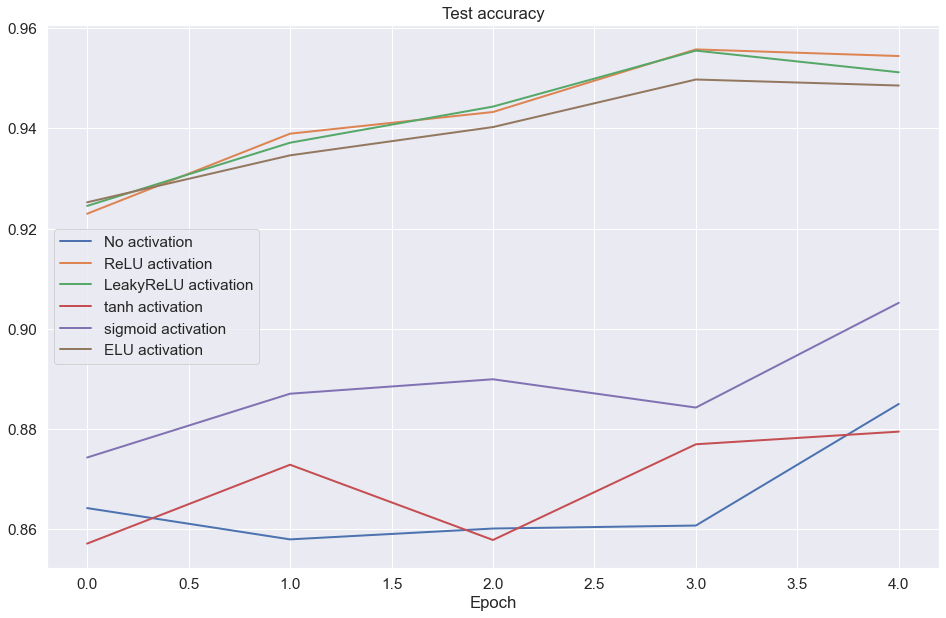

In [62]:
sns.set(style="darkgrid", font_scale=1.4)

x_size = len(relu_accuracy['test'])

plt.figure(figsize=(16, 10))
plt.title("Test accuracy")
plt.plot(range(x_size), plain_accuracy['test'], label="No activation", linewidth=2)
plt.plot(range(x_size), relu_accuracy['test'], label="ReLU activation", linewidth=2)
plt.plot(range(x_size), leaky_relu_accuracy['test'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(x_size), tanh_accuracy['test'], label="tanh activation", linewidth=2)
plt.plot(range(x_size), sigmoid_accuracy['test'], label="sigmoid activation", linewidth=2)
plt.plot(range(x_size), elu_accuracy['test'][:x_size], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Part 2 - convolutional neural networks

### LeNet

Convolutional NN shows much better results in CV. Lets use them!

Our CNN has:
* Convilution 3x3 (1 input, 6 output) with ReLU activation
* MaxPooling-а 2x2
* Convilution 3x3 (6 input, 16 output) with ReLU activation
* MaxPooling-а 2x2
* (nn.Flatten)
* Fully-connected layer with 120 neurons and ReLU activation
* Fully-connected layer with 84  neurons and ReLU activation
* Output layer with 10 neurons




In [66]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

### CNN training

In [22]:
max_epochs = 10
accuracy = {"train": [], "test": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            epoch_correct += (preds == y_batch).sum().item()
            epoch_all += batch_size
            if k == "train":
                print('sus', outp[0:10])
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

sus tensor([[-10.3700,  -2.2266,  -1.5449,  -6.9057,  36.5097, -15.9990,   1.7702,
           3.3691,  -4.4850,   5.3484],
        [ -4.9868,  -7.0700,   9.8669,  15.0731,  -9.1239,  -4.9445, -12.2596,
           6.3110,   4.8628,  -2.7588],
        [-12.8946,  -8.5182,  -1.9799,   2.7854,  17.5751,  -8.2527, -20.6658,
           7.1781,   2.9611,  30.6535],
        [ -7.6485,  37.9550,  -1.1325,  -6.2948,  12.4794,  -7.9004,   4.5750,
          -6.5309,   0.3093, -15.8840],
        [-12.8821,  25.5132,  -5.9599,  -0.9632,   8.9567, -15.3409,  -9.7287,
           4.9471,  -1.3502,   2.2580],
        [  4.8987,   0.4270,  -1.0715,  -3.2008,  -8.8693,   0.1524,   0.8568,
          -3.6787,  14.3236,  -2.9451],
        [ 24.2373, -17.6188,  -7.7760,  10.3788,  -7.0590,   0.3598,  14.5925,
          -2.5324,  -6.0286,  -8.0057],
        [-13.4096,   7.5480,   3.2020,  37.7389, -24.6519,   6.4703, -23.9737,
          -2.7321,   5.7099,   9.0224],
        [-15.4687,  34.6587,   8.2919,  -3.4

sus tensor([[-10.3655,   4.2589,  -0.8717,  19.3298, -20.9938,   8.4674, -14.9756,
          -1.4047,  -0.7345,  -0.9352],
        [ -9.0572,  29.8958,   4.3835,  -4.2428,   4.0802,   0.5152,   4.7723,
          -7.9020,   2.9619, -11.5600],
        [  1.4069,  -5.5839, -16.5900, -10.0840,   6.8371,  -4.9418,  37.1791,
         -22.3153, -13.9962, -15.5113],
        [  1.1486, -11.0906,  -2.8132,  11.3400,  -8.1259,   8.8326,  39.4608,
         -13.3693,  -0.1953,  -7.8847],
        [ 18.9424,  23.4826,   8.5658,   9.6233,   1.0160,  15.2380,  -5.9819,
          63.8515, -15.1595,  18.8904],
        [ -2.2789,  13.5886,  10.3717,   5.3950,  13.9233, -23.6537,  -2.9136,
          35.1189,  -5.7928,  -3.7663],
        [  6.8462,  -5.4056,  -7.5423,   3.7635,   5.3094,  -1.4551,  76.6400,
         -21.3847, -30.9272, -16.6026],
        [  1.9460,  41.4311,   2.4498,  -3.0431,  12.3461,  -7.0118,  -1.7690,
         -10.4413,   7.8169,  -4.4322],
        [  0.1177,  39.5664,   4.0208,  -2.6

sus tensor([[  4.0381,   3.0771,  -1.4060,  -1.1211, -11.5771,  -4.0512,   4.8449,
          -3.2650,  23.4255,  -3.1292],
        [ 54.7272, -20.0845,  10.2599,  -0.8611,  -3.1850,  -4.5809,  -9.2750,
          -5.7820, -10.7850,  10.3817],
        [-10.8576,  -1.5823,   6.5654,  28.1681, -21.2491,   1.5840, -16.9038,
           6.1112,   7.7513,  -0.9690],
        [  2.4237,   4.4923,   0.3707,   0.7526, -10.8833,  -1.3164,   3.9090,
          -1.7447,  21.0548,  -7.9299],
        [  3.1377,  12.8071,   9.4663,   2.2157,  12.9094, -13.0008,  -4.4662,
          38.5952,  -3.5765,   9.2545],
        [ 20.9511,  -1.3404,   5.4875,   5.1662,  12.0257,  17.4461, -12.1216,
          55.5631, -11.7925,  23.3065],
        [-18.4058,  19.2527,  63.2781,  44.7777, -43.0750,  -9.1359,  -8.3284,
          20.1875,  -9.0375, -24.7187],
        [ 10.4949,  13.8064,  22.0768,  16.4188,   5.8715,  -8.5783,  -9.8694,
          43.3664,  -2.3843,  14.7649],
        [ -6.5631,  12.0260,  27.5565,  11.4

sus tensor([[ -3.7561,  -8.3357,   3.1194,   6.1825, -18.6497,  11.0157,  48.2928,
           7.1879,  -3.1799,  -7.0284],
        [ -1.4972,  -5.1088,  -7.5466,  -9.3671,  44.0957, -18.6282, -16.0709,
           4.1803,  -7.4099,  19.6997],
        [ -9.4812,   8.2557,  26.3219,  33.5541, -25.5374,  -8.3030, -17.4942,
          18.4162,   5.6804,  -6.8788],
        [ -3.2217,  -0.5259,  -2.8148,   0.5091,   6.2709,  -3.7049, -13.5674,
           4.0022,   0.2650,  14.1775],
        [  0.1010,   4.1901,   2.3807,   0.3818,  -6.4281,  -2.0994,   0.3957,
          -2.5673,  14.4771,  -1.4146],
        [  1.1065,  -5.0137,   1.5448,   1.1864,  -1.1287,   6.7531,  24.9505,
         -14.3779,  -0.7475,  -0.9130],
        [ -1.4272,   6.6829,   1.9082,   1.2511, -10.3363,  -4.8026,  -0.0719,
          -0.3696,  15.6643,  -6.9050],
        [ -2.9741,   5.1958,   1.8230,   0.3467,  -6.8485,   2.5449,   0.6447,
          -0.7815,  12.7972,  -1.2526],
        [ -0.3354,  13.1150,  61.5577,  11.2

sus tensor([[-6.4408e+00,  6.6868e-01, -1.3524e-01, -8.5945e+00,  4.4486e+01,
         -7.4878e+00, -7.7446e+00, -7.9569e+00, -4.1079e+00,  1.2168e+01],
        [-2.5655e+01,  1.0274e+01, -1.6261e+01, -1.0914e+01,  3.7625e+01,
         -1.3341e+01, -2.0002e+01, -1.0581e-01, -6.8869e+00,  5.4263e+00],
        [-1.0953e+01,  1.9810e+00, -2.9385e+01, -1.6006e+01,  6.3884e+01,
         -1.4530e+01, -1.7840e+01,  1.3869e+01,  5.3621e+00,  2.3456e+01],
        [-2.3743e+00,  6.1149e+00, -1.1410e+00, -4.4756e+00, -6.0969e+00,
          6.0958e+00, -1.8528e+00, -2.2282e+00,  1.6880e+01, -4.2084e+00],
        [ 3.0352e+00, -1.0023e+01, -8.9298e+00,  1.4835e+00,  4.9748e+00,
          1.6979e+00,  1.3877e+01, -4.5089e+00, -7.4252e-01, -7.4661e+00],
        [ 9.9439e+00, -2.5395e+00,  5.9854e-02, -4.8442e+00, -5.8916e+00,
          4.1790e+00, -8.2524e+00, -6.4938e+00,  2.1309e+01,  3.5905e+00],
        [ 1.2496e+01,  2.6904e+00,  5.2956e+00,  8.1952e+00,  4.1737e+00,
          1.5116e+01, -1.668

sus tensor([[-6.8937e+00, -5.5272e-01, -9.7895e+00, -1.6391e+00,  3.2410e+01,
         -9.5138e+00, -3.8267e+00, -4.3114e+00, -1.9924e+00,  9.6315e+00],
        [-2.0659e+00, -2.3064e+00,  4.0766e+00, -5.5715e+00,  1.1772e+00,
         -7.3184e-01, -3.8075e+00, -1.3583e+00, -1.2094e+00, -6.3796e+00],
        [ 4.2422e+01, -2.3711e+01,  1.3576e+01, -1.6268e+01, -2.8929e+00,
          6.0059e+00, -7.0872e+00, -1.6275e+01, -1.1204e+01,  1.5019e+01],
        [-1.7877e+01,  1.0571e+01, -3.6773e+00,  2.7871e+01, -1.3758e+01,
          1.2035e+01, -1.6694e+01, -1.5692e+00,  4.7654e+00,  9.6248e+00],
        [ 2.1020e-02,  2.8774e+00,  3.3303e+00,  7.3649e-02, -4.3271e+00,
          9.0078e+00,  1.0334e-01, -5.4593e+00,  9.7642e+00, -1.4652e+00],
        [ 6.6863e+00, -4.3043e-01,  2.5077e+01,  2.0932e+00,  2.8597e+00,
         -1.4772e+00,  2.3998e+00,  4.1671e+00, -2.3219e+00, -1.7355e+00],
        [ 5.9035e+00,  5.4855e-01,  5.6873e+01,  6.4309e+00,  4.5802e+00,
         -1.7573e-01,  1.182

sus tensor([[-1.4343e+01, -3.1362e+00, -1.7497e+00,  3.4599e+01, -1.5589e+01,
          9.2488e+00, -1.5722e+01, -3.8861e+00,  7.5234e+00,  8.2416e+00],
        [-1.3638e+01,  2.4404e+00, -1.7917e+01, -1.1391e+01,  4.5322e+01,
         -2.0923e+01, -6.0575e+00,  8.9365e+00, -2.9527e+00,  1.7515e+01],
        [ 1.3350e+01, -6.1914e+00, -1.3035e+01, -2.5688e+00,  8.2319e+00,
         -7.3882e-01,  3.9603e+00, -1.7164e+01, -1.0379e+01, -3.4889e+00],
        [-1.1327e+01,  2.5112e+01,  3.9531e+00, -2.5661e+00,  7.9413e+00,
         -1.0160e+01, -4.7193e+00,  9.7580e+00,  4.5781e+00, -4.1935e+00],
        [-2.9103e+01,  4.1063e+00, -1.5946e+01,  1.4616e+01,  6.5612e+01,
          9.2474e-01,  4.4904e+00, -1.3951e+01,  6.5293e-01,  2.0625e+01],
        [-4.6820e+00,  4.7878e+00,  1.7019e+00,  1.5534e+01, -1.2681e+01,
         -3.2686e-01, -1.4743e+01, -2.7909e-01,  4.4042e+00,  4.2403e+00],
        [-1.4859e+00,  2.9070e+01,  1.1439e+01,  3.9608e+00,  2.3342e-02,
         -2.5604e+00,  1.844

sus tensor([[  1.6341,  -5.9951,  -2.1534,  -4.0203,  26.5355, -12.3726, -14.3087,
           0.7140,  -5.5679,  18.0356],
        [ -6.4377,  31.2201,   0.4034,  -6.9440,   0.2691,  -2.3640,   3.1752,
          -7.4014,   3.1316, -17.5308],
        [  7.8596,  -5.9489,   5.6845,   3.9632,  -7.3507,   7.8362,  37.1559,
         -11.3867,  -0.2398, -10.1223],
        [-10.5490,   3.7362,  -4.4470,  -0.9120,  28.0145,  -3.3494, -11.2883,
          -9.1175,   1.7997,   7.2773],
        [ -2.7164,  13.6833, -13.9817,   3.6229,  23.8015, -15.3027, -14.3612,
          12.4396,   3.8639,  39.4683],
        [ -4.7860,  27.9921,   3.7806,  -3.3075,   5.8487,  -7.0387,   0.9098,
           3.1368,   6.5883,  -6.8234],
        [  0.3042,  -6.3669,   8.6139,   3.9733,  -5.0769,  12.1015,  40.9248,
         -12.1449,  -0.7322, -10.8721],
        [-19.2227,  11.7533, -14.2116,  -5.0685,  23.6833,  -0.7303, -10.6586,
          -6.2823,  -1.4071,   1.9115],
        [ -2.9701,   6.1530,   1.7881,  29.7

sus tensor([[ 40.6535,  -8.1082,   9.8952, -14.7818,  -4.6511,   4.1034,  -4.4585,
          -9.6093, -10.8657,   3.2811],
        [ -7.1114,  -1.6354,  -3.7075,  10.7370, -12.2746,  22.9155,   6.9613,
           4.5334,   9.3451,   7.4519],
        [  7.0074,  -3.4711,  11.9501,   5.0482,  -3.9942,   3.4466,  -3.0813,
          29.0586,  -4.6196,   3.1641],
        [  0.4646,   8.8896,  -4.1521,  16.2164,   8.7493,   1.7396, -12.5543,
           6.3696,   8.0354,  26.6483],
        [ -0.4771,  11.2678,  42.7727,   6.7233, -15.6680,  11.8313,   3.9081,
           2.7315,  -0.7065,  -4.9219],
        [ -2.3127,   9.0164,  -3.9428,  10.8891,   7.2640,  -5.1088, -18.9516,
          10.5903,   6.9142,  25.6940],
        [-13.3678,  22.8467,   3.5134,   0.6770,   0.6338,  -3.3649,  -6.4798,
           6.9227,   3.1947,  -3.4450],
        [ -5.0901,  -1.4900,  -7.5170,   1.7356, -14.3272,  16.9318,   5.1298,
          -4.9588,   6.5251,  -2.1526],
        [-10.9912,  41.2395,  13.3645,   5.9

sus tensor([[-11.9277,  21.5731,  -0.6950,   2.8249,  -0.3320,   0.3459,  -8.1379,
           8.0511,   2.9469,   4.7504],
        [ 56.2790, -40.4769, -22.8312, -21.2607,  20.9087,  -0.5855,  29.4490,
         -11.4921, -58.4557, -11.3769],
        [-12.9582,   4.8393,  40.1961,  12.4755, -16.0608,   4.3053,  -5.4287,
          11.3910,   1.6755,  -7.0500],
        [ -0.9181,  30.3154,   3.4026,  -2.0395,  -2.9260,   2.1525,  -1.2331,
          -7.3477,  13.6296,  -9.7107],
        [ -3.3811,  26.9268,   0.6959,  -2.7379,   2.5920,  -2.4966,  -3.7803,
          -2.6106,  10.0283,  -4.6858],
        [ -6.3608,  22.2929,   2.2087,  -4.2446,   6.1328,  -3.1029,   2.4819,
           1.4642,   3.3674, -11.9463],
        [ -7.7506,   3.4167,  -4.0168,  28.3010, -13.7268,   3.3603, -11.0780,
          -3.1489,  13.5875,   6.4748],
        [ -3.1813,   4.8733,   0.4982,   0.8518,  -8.5627,   4.3482,   4.4434,
          -1.5159,  12.4506,  -1.8471],
        [ -0.4121,  11.4531,   5.1980,   9.8

sus tensor([[  3.3987,   5.8727,  33.1475,   7.1654,  -1.4515, -11.0456,  -2.4414,
          11.2273,  -8.1396,  -1.4606],
        [-12.4627,   2.4268,  -6.6868,  37.9068, -20.4856,  19.5270,  -7.1162,
           4.5513,  12.4317,  13.0105],
        [ 13.3384,  -5.9930,  -5.6671,   6.5514,  -2.7735,  -3.7625, -10.8391,
          -3.8781,   2.2380,   7.7839],
        [ -3.6358,   0.6914,  34.0125,  23.8629,   2.9877,   1.2225, -12.6026,
           6.2707,  -1.6911,   6.5843],
        [ -5.0349,  37.7929,  -9.7664,  -0.2817,  13.1051, -20.5925,   1.5385,
          13.0755, -12.0782,   2.1430],
        [-14.4291,  -0.9082,  -6.6457,   2.6384, -29.0195,  39.9681, -14.1314,
           1.9111,   8.7789,  -3.5814],
        [  6.6710, -10.1611,  -0.8364,  -2.9375,   2.5840,   8.2489,  15.2251,
         -14.6275,  -2.4561,   2.7438],
        [ -0.7300,   0.4577,  14.1357,   5.8310,  -2.6911,  -4.8724,  -3.8884,
           8.1149,   0.3751,  -0.8682],
        [ -0.2520,   1.6968,  29.8275,   9.2

sus tensor([[-7.0989e+00, -1.7154e+00,  2.9925e-02,  1.5329e+01, -1.4493e+01,
          1.6088e-01, -4.3804e+00, -4.8689e+00,  5.3105e+00, -7.3586e+00],
        [-9.6964e+00,  2.8673e+01,  3.5270e+00, -4.9299e+00,  1.1937e+01,
         -1.1878e+01, -4.9247e+00,  7.1592e+00,  1.6035e+00, -5.1591e+00],
        [ 1.0101e-01,  6.9313e+00, -5.8251e-01,  9.3177e+00,  5.1452e+00,
          2.8284e+00, -8.4257e+00,  8.2542e+00,  4.3370e+00,  1.6654e+01],
        [-1.3031e+01, -9.4720e-01, -1.3320e+01,  2.0894e+01, -1.5089e+01,
          3.7079e+01,  1.1281e+01,  1.6571e+00,  8.6949e+00,  1.5307e+01],
        [ 4.4902e+01, -2.3030e+01,  1.7314e+01,  6.6070e-01, -1.5838e+01,
          1.5617e+01,  1.1300e+00, -6.3708e+00, -1.8149e+01,  1.8266e+01],
        [-1.4139e+01,  2.0528e+00, -4.8243e+00,  3.3659e+01, -2.4946e+01,
          4.7517e+01,  1.8282e+01,  3.1673e+00,  1.4609e+00,  1.8966e+01],
        [-9.1018e+00,  5.8942e-01,  7.1466e+00,  2.7483e+01, -1.8823e+00,
         -3.4235e+00, -2.540

sus tensor([[-12.1471,   7.2050, -12.9436,   3.1924,  11.8078,  -0.5925, -14.1945,
           1.3020,  -2.6543,  25.6579],
        [ -3.7263,  -0.2392,  13.9096,   2.1419,  -5.0543,   3.3062,   1.2992,
          -2.5935,  20.6731,  -0.8743],
        [ -8.7712,   2.2977, -10.8892,   8.7708, -20.9188,  52.4092,  -3.4368,
           2.6432,  12.8885,   3.0258],
        [ 41.3003, -28.6986,  10.8945, -10.6411,  -3.5511,  15.6148,   1.8203,
           2.9974, -21.2239,  19.5342],
        [ -1.9207,   0.8268,  -2.9855,  -0.2028,   0.2728,  -3.1666,  -4.1036,
          -1.5564,   8.4853,   3.2088],
        [ 31.0250, -23.0848,   5.9291,  -4.6379,  -8.4693,  -5.4687,   2.7976,
         -32.9442,  -7.6102,   1.3960],
        [-11.8219,   3.7676,  23.2670,   4.4627,   3.7207, -16.3106, -12.9083,
           1.5833,  -5.6462,  -2.7092],
        [-17.2154,  37.6419,   8.0810,  -7.3842,   0.2942,  -4.6354,  -4.2780,
          -2.7641,   4.4736, -18.7126],
        [ -1.3915,   5.5630,  17.5514,   3.9

sus tensor([[ -1.6191,   1.6798,   0.1229,   1.1467,  -1.1625,   0.7301,  -0.3202,
          -1.5595,   7.0972,   1.3574],
        [ 53.8339, -24.9558,  -6.8276,  -4.2583,   6.3415,  12.4169,   9.5678,
           4.5038, -40.0312,   2.9424],
        [-12.6840,   1.0081,   0.7514,  48.0180, -27.9452,  12.2124, -18.5832,
           4.4105,  16.3611,  12.0527],
        [ 18.8273, -23.9385,   5.2306,  -5.9064,  -6.7235,   2.9975,  -4.8264,
          -3.9326,   2.0464,   7.2696],
        [-12.4395,  36.3619,   6.2900,  -8.6714,   6.0363,   0.6661,   0.7903,
          -6.6160,  10.1492, -16.9294],
        [ 64.6045, -30.5405,  -7.2447,  -6.0597,  -2.1500,   2.4566,  13.2951,
         -28.0290, -37.6954,  -1.9719],
        [-10.8171,  -3.6955,  35.3858,  20.5697, -30.0818,   4.6315,  -3.5880,
           9.3030,   5.8326, -15.4305],
        [-19.0272,   4.8834, -14.9621,   6.3447,  22.0647,  -5.6139,  -3.3134,
          -4.0627,  -6.1692,  12.3636],
        [ 18.0353, -10.0991,   7.3043,   7.9

sus tensor([[ 14.7423,  -7.1574,   7.5661,  -1.6630,  -4.9626,   1.6194, -10.2823,
          -2.5165,  -6.2246,   4.4187],
        [ -0.2360,   1.4431,   5.0167,  12.3387,  -8.8368,  -4.6109,  -9.7621,
          -0.5957,  22.3292,   2.1783],
        [-12.9339,   5.3634,  -4.0425,  10.6995,  -7.2836,  -0.2470,  17.1958,
          -0.4498,   7.0964,  -8.3066],
        [-18.5695,  10.2282,  45.1064,  25.3448, -32.7864,  -2.6487,   0.6905,
           5.6967,   6.9438, -18.6190],
        [ -4.6142,  60.2839, -12.3714,  -8.5621,  19.6248, -25.5911,  16.4709,
          12.9463, -11.5744,   0.1277],
        [  8.8920, -14.2248, -11.1475,  12.8093,   8.1028,  -0.7060,  36.1300,
         -15.6717, -13.0864, -13.7688],
        [ 35.1763, -10.3391,   1.8073,  -9.0923, -13.8992,  -2.7193,  -1.7446,
         -40.2532,  -7.2210, -10.7776],
        [  9.7114,  -4.5610,  41.1476,  20.7930,  -6.1026,   1.6704,  -9.5707,
          16.5536,  -5.7554,   8.2953],
        [  1.4116,   8.8266,  -5.9910,  16.4

sus tensor([[ 12.6878,   0.8873,   1.3849,   5.5216,  12.9559,  -9.9107, -19.3848,
          16.3944,   0.6716,  27.2943],
        [-12.4500, -31.5069,  -1.8694,  30.7776, -38.0195,  13.8022,  -3.5663,
         -12.1934,  15.5770,  -4.0603],
        [  3.6090,  -6.5419,  18.8857,   6.2087,  -4.1728,  -0.1889,  -0.4463,
          34.4080,  -1.2699,  -1.8265],
        [ -3.9417,  31.4131,   1.2940,  -7.2140,   5.9502,   4.7054,   1.0656,
         -11.0837,   7.4538, -13.5578],
        [ 29.1344,  29.0468,  32.8359,   8.4847,  21.5988,  -9.2720, -11.3091,
          76.5309, -18.1637,  29.6607],
        [ -1.0542,   2.8079,   4.7055,   6.8811,  -7.1024,  -1.3103,  -2.0062,
          -0.6364,  12.2263,  -4.0831],
        [ -9.4738,  -3.8051,  35.8073,  18.5386, -23.6154,  -1.0026,  -9.2054,
          10.2740,  -6.3717,  -6.4504],
        [  3.4293, -15.5990,   0.9526,   7.7988,   6.7243,   5.3442,  40.4979,
         -19.7311,  -5.4217, -10.1141],
        [ -6.3984,  -6.2074, -11.5497,  14.0

sus tensor([[ -2.6457,  12.0516,  14.1968,  11.4726,   2.5710, -16.8612, -10.7372,
          30.2854,  -1.6071,   0.6757],
        [  6.2314, -13.4670,   9.4374,  -6.6696,  25.9934,  -4.3113,   7.1545,
          -8.5243,  -9.5664,   3.8028],
        [ 52.3362, -46.7056,  11.4731,  -8.3563,  -6.9338,  16.8903,  -8.8411,
           2.3486, -21.5925,  24.8300],
        [-13.4033,  17.6162,   7.3044,  15.2563,   6.6215,  -5.9499, -20.1372,
          30.9491,   4.4274,  21.7615],
        [-21.8601,  -8.6176,  -6.1985,  22.3223, -22.2384,  43.2724, -10.7599,
          -4.0206,  -5.8470,   6.9952],
        [ -6.9559,   2.8473,   1.0279,  48.1942, -25.2073,  21.5360, -10.8363,
           7.8825,   7.6781,  14.6711],
        [ -1.0867,   2.9564,   2.4857,   0.9541,  -2.1925,   3.1147,   6.9785,
          -0.5579,  10.5521,  -1.9564],
        [  1.8358, -22.4556,  -2.4510,   2.4292,  -1.4308,  11.5578,  30.6229,
         -15.5247,  -2.8046,  -6.6338],
        [ -8.2297,  -4.7483,  -7.9857,  11.7

KeyboardInterrupt: 

In [69]:
lenet_accuracy = accuracy

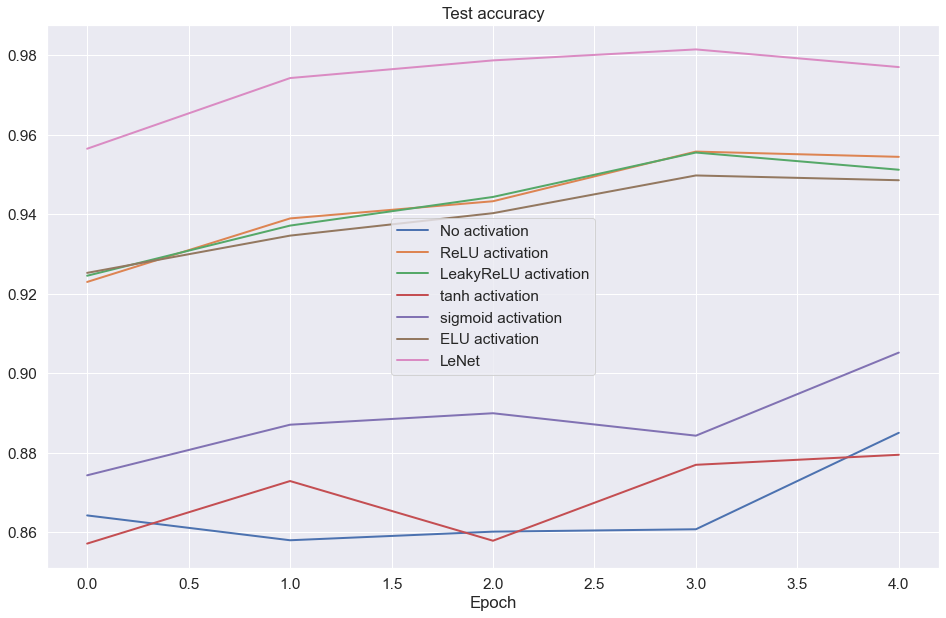

In [70]:
plt.figure(figsize=(16, 10))
plt.title("Test accuracy")
plt.plot(range(x_size), plain_accuracy['test'], label="No activation", linewidth=2)
plt.plot(range(x_size), relu_accuracy['test'], label="ReLU activation", linewidth=2)
plt.plot(range(x_size), leaky_relu_accuracy['test'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(x_size), tanh_accuracy['test'], label="tanh activation", linewidth=2)
plt.plot(range(x_size), sigmoid_accuracy['test'], label="sigmoid activation", linewidth=2)
plt.plot(range(x_size), elu_accuracy['test'][:x_size], label="ELU activation", linewidth=2)
plt.plot(range(x_size), lenet_accuracy['test'][:x_size], label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()



**Result:** `epochs = 10 -> accuracy = 0.988`

# Training on the full dataset


In [71]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

batch_size = 280 # this number should be a divider of test size!!
train_dataset = CustomDataset(train_filename, True, transform=data_tfs)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=2)

loaders = {"train": train_dataloader}
max_epochs = 35
accuracy = {"train": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            model.train()
            optimizer.zero_grad()
            outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  batch_size
            epoch_correct += correct.item()
            epoch_all += all
            optimizer.zero_grad()
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Downloaded dataset with size:  (42000, 785)
Epoch: 1
Loader: train. Accuracy: 0.8677380952380952
Epoch: 2
Loader: train. Accuracy: 0.9688809523809524
Epoch: 3
Loader: train. Accuracy: 0.9793809523809524
Epoch: 4
Loader: train. Accuracy: 0.9851666666666666
Epoch: 5
Loader: train. Accuracy: 0.987904761904762
Epoch: 6
Loader: train. Accuracy: 0.9895952380952381
Epoch: 7
Loader: train. Accuracy: 0.9926190476190476
Epoch: 8
Loader: train. Accuracy: 0.9935
Epoch: 9
Loader: train. Accuracy: 0.9943571428571428
Epoch: 10
Loader: train. Accuracy: 0.9950238095238095
Epoch: 11
Loader: train. Accuracy: 0.9945714285714286
Epoch: 12
Loader: train. Accuracy: 0.9955238095238095
Epoch: 13
Loader: train. Accuracy: 0.9962857142857143
Epoch: 14
Loader: train. Accuracy: 0.9961666666666666
Epoch: 15
Loader: train. Accuracy: 0.9962857142857143
Epoch: 16
Loader: train. Accuracy: 0.9979285714285714
Epoch: 17
Loader: train. Accuracy: 0.9955238095238095
Epoch: 18
Loader: train. Accuracy: 0.9958571428571429
Epoch:

In [76]:
real_test_dataset = CustomDataset(test_filename, False, transform=data_tfs)
real_test_dataloader = DataLoader(real_test_dataset, batch_size=batch_size, drop_last=True, num_workers=2)

Downloaded dataset with size:  (28000, 784)


In [77]:
print("------real_test-----")
for x, y in real_test_dataloader:
  print(x.shape)
  print(x.dtype)
  print(y)
  break

------real_test-----
torch.Size([280, 1, 28, 28])
torch.float32
tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

In [79]:
model.eval()
preds = []
total_tests = 0

for x_batch, _ in real_test_dataloader:
    total_tests += len(_)
    x_batch = x_batch.to(device)
    outp = model(x_batch)
    current_preds = outp.argmax(-1)
    preds += current_preds.cpu().tolist()

print("Calculated answers for", total_tests, "rows")

Calculated answers for 28000 rows


In [80]:
pd.DataFrame(preds)

,0
0,2
1,0
2,9
3,9
4,3
...,...
27995,9
27996,7
27997,3
27998,9


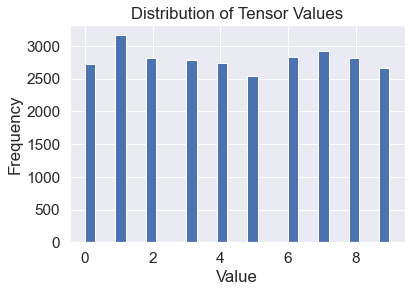

In [81]:
numpy_array = preds

plt.hist(numpy_array, bins=30)
plt.title("Distribution of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [82]:
export = pd.DataFrame({'ImageId': range(1, 28001),
                       'Label': preds})

export.to_csv("./answers.csv", index=False)